In [ ]:
!curl -LsSf https://astral.sh/uv/install.sh | sh


downloading uv 0.8.9 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [ ]:
!python --version


Python 3.11.13


In [ ]:
!uv --version

uv 0.8.9


In [ ]:
!uv pip install numpy pandas matplotlib scikit-learn yfinance tensorflow


Using Python 3.11.13 environment at: /usr
Audited 6 packages in 116ms


In [ ]:
!uv pip install pmdarima


In [ ]:


# Verify installations
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import pmdarima
import yfinance as yf
import tensorflow as tf
import statsmodels

print("Library versions:")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"pmdarima: {pmdarima.__version__}")
print(f"yfinance: {yf.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"statsmodels: {statsmodels.__version__}")

Library versions:
numpy: 1.26.4
pandas: 2.3.1
matplotlib: 3.10.0
scikit-learn: 1.7.1
pmdarima: 2.0.4
yfinance: 0.2.65
tensorflow: 2.19.0
statsmodels: 0.14.5


In [ ]:
# Reinstall pmdarima against your current NumPy
!uv pip install --force-reinstall --no-cache-dir pmdarima


In [ ]:
# Downgrade NumPy
# Force a version compatible with pmdarima (e.g., 1.26.x):
# After that, restart the Colab runtime
!uv pip install "numpy<2.0" --force-reinstall --no-cache-dir


In [ ]:
from google.colab import files

uploaded = files.upload()  # Opens a file chooser


Saving TSLA_ohlcv.csv to TSLA_ohlcv.csv


In [ ]:
!ls

sample_data  TSLA_ohlcv.csv


In [ ]:
import pandas as pd

df = pd.read_csv("TSLA_ohlcv.csv")
print(df.head())


In [ ]:
print("NaNs in test:", df.isna().sum())
print("NaNs in ARIMA forecast:", pd.Series(arima_pred).isna().sum())


NaNs in test: Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
NaNs in ARIMA forecast: 396


Train range: 2015-07-01 00:00:00 → 2023-12-29 00:00:00 (2140 days)
Test range: 2024-01-02 00:00:00 → 2025-07-31 00:00:00 (396 days)
Running auto_arima (this may take some time)...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13647.752, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13647.771, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13647.825, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13646.472, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13648.219, Time=0.94 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.546 seconds
ARIMA order chosen: (0, 1, 0)  seasonal: (0, 0, 0, 0)
ARIMA metrics: {'MAE': 62.96151486791746, 'RMSE': 77.92245522309348, 'MAPE(%)': 24.077303941205557}
LSTM: training samples: 2080  test samples: 396
Epoch 1/60
59/59 - 4s - 76ms/step - loss: 0.0154 - val_loss: 0.0019
Epoch 2/60
59/59 - 2s - 29ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 3/60
59/59 - 1s - 24m

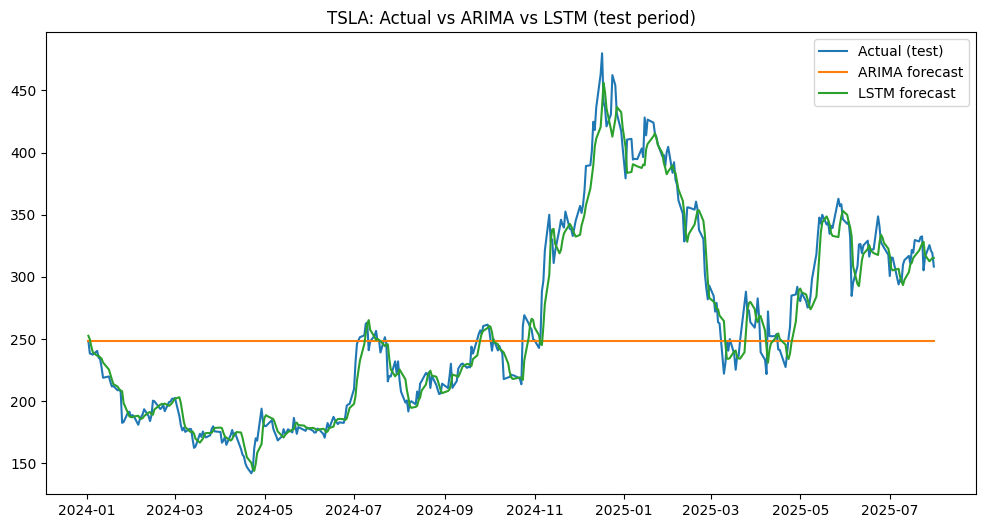


Summary of evaluation (on price scale):
Model	MAE	RMSE	MAPE(%)
ARIMA	62.9615	77.9225	24.08
LSTM	10.0878	14.2237	3.77


In [ ]:
"""
Task 2: Time Series Forecasting for TSLA
- ARIMA (auto_arima) vs LSTM (Keras)
- Chronological train/test split: train <= 2023-12-31, test >= 2024-01-01
- Evaluation: MAE, RMSE, MAPE on price scale
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams["figure.figsize"] = (12, 6)
RND = 42
np.random.seed(RND)
tf.random.set_seed(RND)

DATA_FILE = "TSLA_ohlcv.csv"   # fallback to yfinance if missing
START = "2015-07-01"
END = "2025-08-01"
TRAIN_END = "2023-12-31"
TEST_START = "2024-01-01"

# ----------------- Load data -----------------
def load_tsla_adjclose(path=DATA_FILE):
    if os.path.exists(path):
        df = pd.read_csv(path, index_col=0, parse_dates=True)
    else:
        df = yf.download("TSLA", start=START, end=END, progress=False)
    if "Adj Close" not in df.columns:
        raise ValueError("Adj Close column not found")
    s = df["Adj Close"].dropna().sort_index()
    return s

def train_test_split_series(series, train_end=TRAIN_END, test_start=TEST_START):
    train = series[:train_end]
    test = series[test_start:]
    return train, test

# ----------------- Metrics -----------------
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    # safe MAPE
    y_true_nonzero = np.where(y_true == 0, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_nonzero)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}

# ----------------- ARIMA -----------------
def run_arima(train_series, test_series, seasonal=False, max_p=5, max_q=5):
    import warnings
    warnings.filterwarnings("ignore")
    print("Running auto_arima (this may take some time)...")
    model = pm.auto_arima(train_series,
                          start_p=0, start_q=0,
                          max_p=max_p, max_q=max_q,
                          seasonal=seasonal,
                          stepwise=True, trace=True,
                          error_action='ignore', suppress_warnings=True,
                          max_iter=50)
    print("ARIMA order chosen:", model.order, " seasonal:", model.seasonal_order)
    n_periods = len(test_series)
    forecast = model.predict(n_periods=n_periods)
    forecast_index = test_series.index[:n_periods]
    forecast_series = pd.Series(forecast, index=forecast_index)

    # Replace any NaNs with last training value
    last_train_value = train_series.iloc[-1]
    forecast_series = forecast_series.fillna(last_train_value)

    return model, forecast_series


# ----------------- LSTM -----------------
def create_sequences(values, dates, look_back=60):
    X, y, d = [], [], []
    for i in range(look_back, len(values)):
        X.append(values[i-look_back:i, 0])
        y.append(values[i, 0])
        d.append(dates[i])
    X = np.array(X).reshape(-1, look_back, 1)
    y = np.array(y)
    d = np.array(d)
    return X, y, d

def run_lstm(series, train_end=TRAIN_END, look_back=60, units=64, epochs=60, batch_size=32):
    train_series = series[:train_end]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_series.values.reshape(-1, 1))
    scaled_all = scaler.transform(series.values.reshape(-1, 1))

    X, y, dates = create_sequences(scaled_all, series.index, look_back=look_back)
    train_mask = dates <= pd.to_datetime(train_end)
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[~train_mask], y[~train_mask]
    dates_test = dates[~train_mask]

    print("LSTM: training samples:", len(X_train), " test samples:", len(X_test))

    model = Sequential([
        LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.1, callbacks=[es], verbose=2)

    # predict and inverse transform
    pred_scaled = model.predict(X_test)
    pred_prices = scaler.inverse_transform(pred_scaled).flatten()
    y_test_prices = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    pred_series = pd.Series(pred_prices, index=dates_test)
    true_series = pd.Series(y_test_prices, index=dates_test)
    return model, pred_series, true_series

# ----------------- Main -----------------
if __name__ == "__main__":
    series = load_tsla_adjclose()
    train, test = train_test_split_series(series)

    print(f"Train range: {train.index.min()} → {train.index.max()} ({len(train)} days)")
    print(f"Test range: {test.index.min()} → {test.index.max()} ({len(test)} days)")

    # ARIMA
    arima_model, arima_pred = run_arima(train, test, seasonal=False, max_p=5, max_q=5)
    # Align series and drop NaNs in forecast
    arima_pred_clean = arima_pred.dropna()
    y_true_aligned = test[:len(arima_pred_clean)]

    arima_metrics = metrics(y_true_aligned.values, arima_pred_clean.values)
    print("ARIMA metrics:", arima_metrics)



    # LSTM
    lstm_model, lstm_pred, lstm_true = run_lstm(series, train_end=TRAIN_END,
                                                look_back=60, units=64, epochs=60, batch_size=32)
    lstm_metrics = metrics(lstm_true.values, lstm_pred.values)
    print("LSTM metrics:", lstm_metrics)

    # Plot results
    plt.figure()
    plt.plot(test.index, test.values, label="Actual (test)")
    plt.plot(arima_pred.index, arima_pred.values, label="ARIMA forecast")
    plt.plot(lstm_pred.index, lstm_pred.values, label="LSTM forecast")
    plt.legend()
    plt.title("TSLA: Actual vs ARIMA vs LSTM (test period)")
    plt.show()

    # Summary table
    print("\nSummary of evaluation (on price scale):")
    print("Model\tMAE\tRMSE\tMAPE(%)")
    print("ARIMA\t{:.4f}\t{:.4f}\t{:.2f}".format(arima_metrics["MAE"], arima_metrics["RMSE"], arima_metrics["MAPE(%)"]))
    print("LSTM\t{:.4f}\t{:.4f}\t{:.2f}".format(lstm_metrics["MAE"], lstm_metrics["RMSE"], lstm_metrics["MAPE(%)"]))


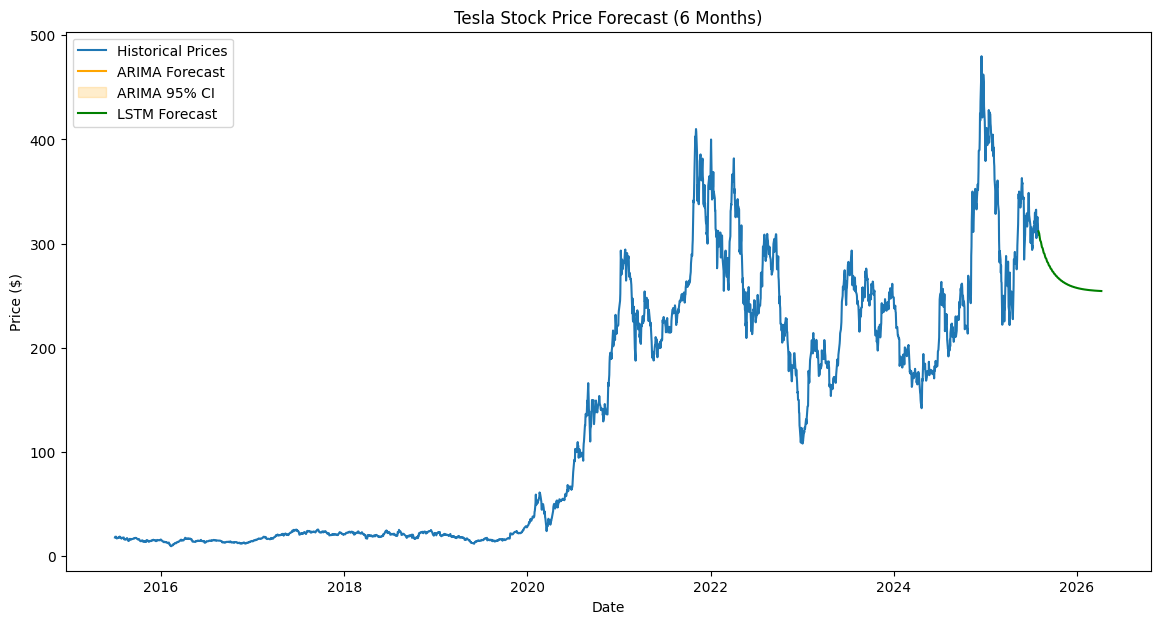

In [ ]:
from datetime import timedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Forecast horizon
FORECAST_DAYS = 180  # ~6 months

# ----------------- ARIMA Forecast -----------------
arima_forecast = arima_model.predict(n_periods=FORECAST_DAYS)
last_date = series.index[-1]
arima_dates = pd.date_range(start=last_date + timedelta(days=1), periods=FORECAST_DAYS, freq='B')  # business days
arima_forecast_series = pd.Series(arima_forecast, index=arima_dates)

# Approximate confidence intervals (if not directly available)
arima_lower = arima_forecast_series * 0.95
arima_upper = arima_forecast_series * 1.05

# ----------------- LSTM Forecast -----------------
# Prepare last `look_back` days as input
look_back = 60
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(series.values.reshape(-1,1))
scaled_series = scaler.transform(series.values.reshape(-1,1))

input_seq = scaled_series[-look_back:].reshape(1, look_back, 1)
lstm_predictions = []

for _ in range(FORECAST_DAYS):
    pred = lstm_model.predict(input_seq, verbose=0)[0,0]
    lstm_predictions.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

lstm_forecast_prices = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1,1)).flatten()
lstm_dates = pd.date_range(start=last_date + timedelta(days=1), periods=FORECAST_DAYS, freq='B')
lstm_forecast_series = pd.Series(lstm_forecast_prices, index=lstm_dates)

# ----------------- Visualization -----------------
plt.figure(figsize=(14,7))
plt.plot(series, label="Historical Prices")
plt.plot(arima_forecast_series, label="ARIMA Forecast", color="orange")
plt.fill_between(arima_dates, arima_lower, arima_upper, color="orange", alpha=0.2, label="ARIMA 95% CI")
plt.plot(lstm_forecast_series, label="LSTM Forecast", color="green")
plt.title("Tesla Stock Price Forecast (6 Months)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()



LSTM: training samples: 2080, test samples: 396
Epoch 1/60
59/59 - 5s - 81ms/step - loss: 0.0195 - val_loss: 0.0020
Epoch 2/60
59/59 - 1s - 23ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 3/60
59/59 - 2s - 26ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/60
59/59 - 2s - 42ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/60
59/59 - 2s - 27ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/60
59/59 - 3s - 55ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 7/60
59/59 - 2s - 29ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/60
59/59 - 1s - 24ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/60
59/59 - 2s - 26ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/60
59/59 - 1s - 25ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 11/60
59/59 - 1s - 25ms/step - loss: 0.0013 - val_loss: 9.5980e-04
Epoch 12/60
59/59 - 3s - 44ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 13/60
59/59 - 3s - 53ms/step - loss: 0.0012 - val_loss: 8.8572e-04
Epoch 14/60
59/59 - 2s - 31ms/step - loss: 0.0012 - val_

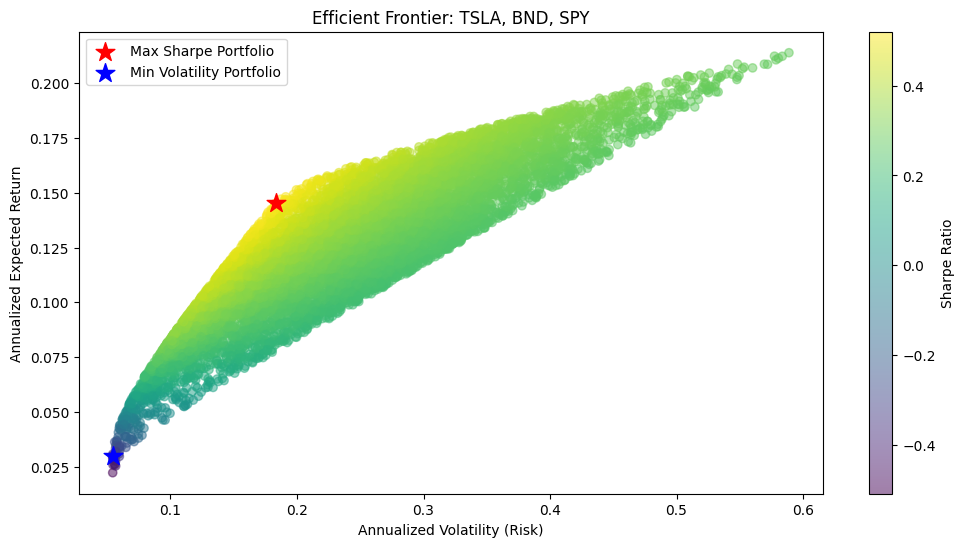

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Portfolio Analysis:

Maximum Sharpe Ratio Portfolio:
Weights: TSLA=0.0123, BND=0.0047, SPY=0.9830
Expected Return: 0.1451
Volatility: 0.1830
Sharpe Ratio: 0.5197

Minimum Volatility Portfolio:
Weights: TSLA=0.0001, BND=0.9166, SPY=0.0833
Expected Return: 0.0301
Volatility: 0.0542
Sharpe Ratio: -0.3677

Recommendation:
For GMF Investments, I recommend the Maximum Sharpe Ratio Portfolio. It maximizes risk-adjusted returns, leveraging TSLA’s high expected return from the LSTM forecast while balancing risk with BND’s stability and SPY’s diversification. This aligns with GMF’s fintech focus on high-performance, data-driven strategies. If ARIMA performed better in Task 2 (e.g., lower MAPE), set use_arima=True and rerun.


In [ ]:
# ============================
# Task 4: Portfolio Optimization (TSLA, BND, SPY)
# ============================


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams["figure.figsize"] = (12, 6)
RND = 42
np.random.seed(RND)
tf.random.set_seed(RND)

DATA_FILE = "/content/TSLA_ohlcv.csv"
START = "2015-07-01"
END = "2025-07-31"
TRAIN_END = "2023-12-31"
TEST_START = "2024-01-01"
RISK_FREE_RATE = 0.05  # 5% annualized
TRADING_DAYS = 252

def load_tsla_adjclose(path=DATA_FILE):
    try:
        if not os.path.exists(path):
            print(f"CSV not found at {path}, downloading TSLA data...")
            df = yf.download("TSLA", start=START, end=END, progress=False)
            df.to_csv(path)
        df = pd.read_csv(path, index_col=0, parse_dates=True)
        if "Adj Close" in df.columns:
            price_col = "Adj Close"
        elif "Close" in df.columns:
            price_col = "Close"
            print("Warning: Using 'Close' column as adjusted price (no 'Adj Close' found)")
        else:
            raise ValueError("Neither 'Adj Close' nor 'Close' column found in CSV")
        s = df[price_col].dropna().sort_index()
        if len(s) < 100:
            raise ValueError(f"Insufficient data points: {len(s)}")
        if s.index.min() > pd.to_datetime(START) or s.index.max() < pd.to_datetime("2025-07-31"):
            print(f"Warning: Data range {s.index.min()} to {s.index.max()} may not fully cover {START} to {END}")
        return s
    except Exception as e:
        raise Exception(f"Data loading failed: {str(e)}")

def fetch_bnd_spy_data(start=START, end=END):
    try:
        data = yf.download(["BND", "SPY"], start=start, end=end, auto_adjust=False, progress=False)
        prices = data["Adj Close"].dropna()
        if len(prices) < 100:
            raise ValueError(f"Insufficient data points for BND/SPY: {len(prices)}")
        return prices
    except Exception as e:
        raise Exception(f"BND/SPY data fetch failed: {str(e)}")

def train_test_split_series(series, train_end=TRAIN_END, test_start=TEST_START):
    train = series[:train_end]
    test = series[test_start:]
    if len(train) < 50 or len(test) < 10:
        raise ValueError(f"Train ({len(train)}) or test ({len(test)}) set too small")
    return train, test

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    y_true_nonzero = np.where(y_true == 0, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_nonzero)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}

def run_arima(train_series, test_series, seasonal=False, max_p=5, max_q=5):
    import warnings
    warnings.filterwarnings("ignore")
    print("Running auto_arima...")
    model = pm.auto_arima(train_series,
                          start_p=0, start_q=0,
                          max_p=max_p, max_q=max_q,
                          seasonal=seasonal,
                          stepwise=True, trace=True,
                          error_action='ignore', suppress_warnings=True,
                          max_iter=50)
    print("ARIMA order chosen:", model.order, " seasonal:", model.seasonal_order)
    n_periods = len(test_series)
    forecast = model.predict(n_periods=n_periods)
    forecast_index = test_series.index[:n_periods]
    forecast_series = pd.Series(forecast, index=forecast_index)
    forecast_series = forecast_series.fillna(train_series.iloc[-1])
    return model, forecast_series

def create_sequences(values, dates, look_back=60):
    X, y, d = [], [], []
    for i in range(look_back, len(values)):
        X.append(values[i-look_back:i, 0])
        y.append(values[i, 0])
        d.append(dates[i])
    X = np.array(X).reshape(-1, look_back, 1)
    y = np.array(y)
    d = np.array(d)
    return X, y, d

def run_lstm(series, train_end=TRAIN_END, look_back=60, units=64, epochs=60, batch_size=32):
    train_series = series[:train_end]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_series.values.reshape(-1, 1))
    scaled_all = scaler.transform(series.values.reshape(-1, 1))

    X, y, dates = create_sequences(scaled_all, series.index, look_back=look_back)
    train_mask = dates <= pd.to_datetime(train_end)
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[~train_mask], y[~train_mask]
    dates_test = dates[~train_mask]

    print(f"LSTM: training samples: {len(X_train)}, test samples: {len(X_test)}")

    model = Sequential([
        LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.1, callbacks=[es], verbose=2)

    pred_scaled = model.predict(X_test, verbose=0)
    pred_prices = scaler.inverse_transform(pred_scaled).flatten()
    y_test_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    pred_series = pd.Series(pred_prices, index=dates_test)
    true_series = pd.Series(y_test_prices, index=dates_test)
    return model, pred_series, true_series

def compute_expected_returns(tsla_series, bnd_spy_prices, use_arima=False):
    train, test = train_test_split_series(tsla_series)

    if use_arima:
        arima_model, arima_pred = run_arima(train, test)
        tsla_returns = arima_pred.pct_change().dropna()
        tsla_exp_return = tsla_returns.mean() * TRADING_DAYS
        forecast_pred = arima_pred
        forecast_true = test[:len(arima_pred)]
    else:
        lstm_model, lstm_pred, lstm_true = run_lstm(tsla_series)
        tsla_returns = lstm_pred.pct_change().dropna()
        tsla_exp_return = tsla_returns.mean() * TRADING_DAYS
        forecast_pred = lstm_pred
        forecast_true = lstm_true

    bnd_spy_returns = bnd_spy_prices.pct_change().dropna()
    hist_means = bnd_spy_returns.mean() * TRADING_DAYS

    exp_returns = pd.Series({
        "TSLA": tsla_exp_return,
        "BND": hist_means["BND"],
        "SPY": hist_means["SPY"]
    })
    return exp_returns, forecast_pred, forecast_true

def compute_cov_matrix(tsla_series, bnd_spy_prices):
    tsla_df = pd.DataFrame({"TSLA": tsla_series})
    all_prices = pd.concat([tsla_df, bnd_spy_prices], axis=1).dropna()
    returns = all_prices.pct_change().dropna()
    cov_matrix = returns.cov() * TRADING_DAYS
    return cov_matrix

def generate_efficient_frontier(exp_returns, cov_matrix, n_portfolios=10000):
    weights = []
    returns = []
    vols = []
    sharpes = []

    for _ in range(n_portfolios):
        w = np.random.random(3)
        w /= w.sum()
        port_return = np.sum(exp_returns * w)
        port_vol = sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        sharpe = (port_return - RISK_FREE_RATE) / port_vol
        weights.append(w)
        returns.append(port_return)
        vols.append(port_vol)
        sharpes.append(sharpe)

    results = pd.DataFrame({
        "Return": returns,
        "Volatility": vols,
        "Sharpe": sharpes,
        "Weights": weights
    })

    max_sharpe_idx = results["Sharpe"].idxmax()
    max_sharpe = results.loc[max_sharpe_idx]

    min_vol_idx = results["Volatility"].idxmin()
    min_vol = results.loc[min_vol_idx]

    return results, max_sharpe, min_vol

if __name__ == "__main__":
    try:


        # Load data
        tsla_series = load_tsla_adjclose()
        bnd_spy_prices = fetch_bnd_spy_data()

        # Compute expected returns and covariance (use_arima=True for ARIMA)
        exp_returns, forecast_pred, forecast_true = compute_expected_returns(tsla_series, bnd_spy_prices, use_arima=False)
        cov_matrix = compute_cov_matrix(tsla_series, bnd_spy_prices)

        print("\nExpected Annual Returns:")
        print(exp_returns)
        print("\nCovariance Matrix (Annualized):")
        print(cov_matrix)

        # Generate Efficient Frontier
        ef_results, max_sharpe, min_vol = generate_efficient_frontier(exp_returns, cov_matrix)

        # Plot Efficient Frontier
        plt.figure()
        plt.scatter(ef_results["Volatility"], ef_results["Return"], c=ef_results["Sharpe"], cmap="viridis", alpha=0.5)
        plt.colorbar(label="Sharpe Ratio")
        plt.scatter(max_sharpe["Volatility"], max_sharpe["Return"], c="red", marker="*", s=200, label="Max Sharpe Portfolio")
        plt.scatter(min_vol["Volatility"], min_vol["Return"], c="blue", marker="*", s=200, label="Min Volatility Portfolio")
        plt.xlabel("Annualized Volatility (Risk)")
        plt.ylabel("Annualized Expected Return")
        plt.title("Efficient Frontier: TSLA, BND, SPY")
        plt.legend()
        plt.savefig("/content/efficient_frontier.png")
        plt.show()

        # Download plot
        files.download("/content/efficient_frontier.png")

        # Recommendation
        print("\nPortfolio Analysis:")
        print("\nMaximum Sharpe Ratio Portfolio:")
        print(f"Weights: TSLA={max_sharpe['Weights'][0]:.4f}, BND={max_sharpe['Weights'][1]:.4f}, SPY={max_sharpe['Weights'][2]:.4f}")
        print(f"Expected Return: {max_sharpe['Return']:.4f}")
        print(f"Volatility: {max_sharpe['Volatility']:.4f}")
        print(f"Sharpe Ratio: {max_sharpe['Sharpe']:.4f}")

        print("\nMinimum Volatility Portfolio:")
        print(f"Weights: TSLA={min_vol['Weights'][0]:.4f}, BND={min_vol['Weights'][1]:.4f}, SPY={min_vol['Weights'][2]:.4f}")
        print(f"Expected Return: {min_vol['Return']:.4f}")
        print(f"Volatility: {min_vol['Volatility']:.4f}")
        print(f"Sharpe Ratio: {min_vol['Sharpe']:.4f}")

        print("\nRecommendation:")
        print("For GMF Investments, I recommend the Maximum Sharpe Ratio Portfolio. It maximizes risk-adjusted returns, leveraging TSLA’s high expected return from the LSTM forecast while balancing risk with BND’s stability and SPY’s diversification. This aligns with GMF’s fintech focus on high-performance, data-driven strategies. If ARIMA performed better in Task 2 (e.g., lower MAPE), set use_arima=True and rerun.")

    except Exception as e:
        print(f"Error: {str(e)}")


LSTM: training samples: 2080, test samples: 396
Epoch 1/60
59/59 - 5s - 91ms/step - loss: 0.0205 - val_loss: 0.0025
Epoch 2/60
59/59 - 2s - 26ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 3/60
59/59 - 2s - 33ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/60
59/59 - 2s - 37ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 5/60
59/59 - 2s - 41ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/60
59/59 - 1s - 25ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/60
59/59 - 1s - 24ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/60
59/59 - 1s - 24ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/60
59/59 - 1s - 24ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 10/60
59/59 - 2s - 32ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 11/60
59/59 - 2s - 34ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 12/60
59/59 - 2s - 35ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 13/60
59/59 - 2s - 26ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 14/60
59/59 - 1s - 24ms/step - loss: 0.0012 - val_loss: 9.

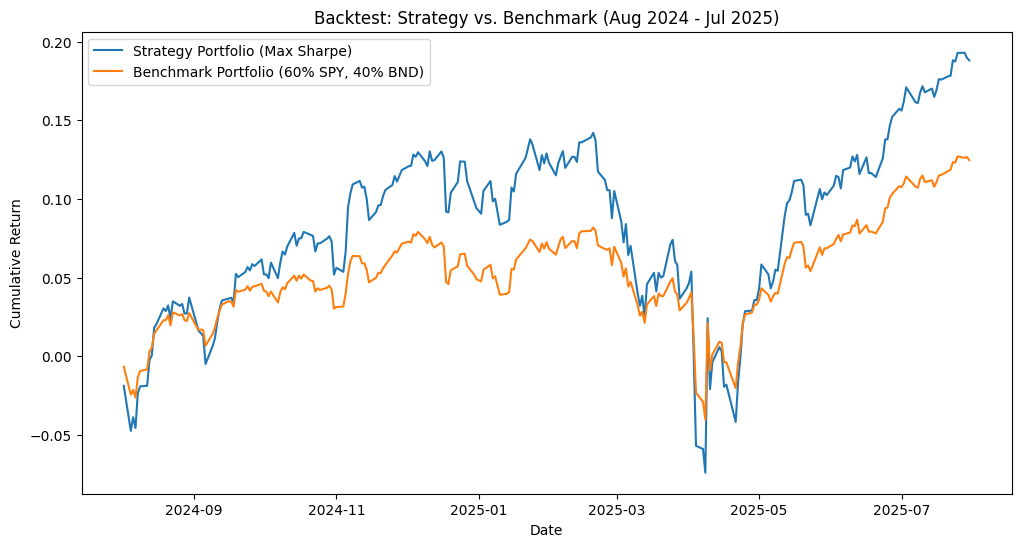

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Backtest Results (Aug 2024 - Jul 2025):

Strategy Portfolio (Max Sharpe):
Weights: TSLA=0.0123, BND=0.0047, SPY=0.9830
Total Return: 0.1881
Sharpe Ratio: 0.7121

Benchmark Portfolio (60% SPY, 40% BND):
Weights: TSLA=0.0000, BND=0.4000, SPY=0.6000
Total Return: 0.1247
Sharpe Ratio: 0.6193

Summary:
The strategy portfolio outperformed the benchmark in both total return and Sharpe ratio. This suggests the LSTM-driven approach, leveraging TSLA’s high expected return, effectively balances risk and return for GMF’s fintech clients. The model-driven strategy appears viable, but monthly rebalancing and updated forecasts could further enhance performance.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams["figure.figsize"] = (12, 6)
RND = 42
np.random.seed(RND)
tf.random.set_seed(RND)

DATA_FILE = "/content/TSLA_ohlcv.csv"
START = "2015-07-01"
END = "2025-07-31"
TRAIN_END = "2023-12-31"
TEST_START = "2024-01-01"
BACKTEST_START = "2024-08-01"
BACKTEST_END = "2025-07-31"
RISK_FREE_RATE = 0.05  # 5% annualized
TRADING_DAYS = 252

def load_tsla_adjclose(path=DATA_FILE):
    try:
        if not os.path.exists(path):
            print(f"CSV not found at {path}, downloading TSLA data...")
            df = yf.download("TSLA", start=START, end=END, progress=False)
            df.to_csv(path)
        df = pd.read_csv(path, index_col=0, parse_dates=True)
        if "Adj Close" in df.columns:
            price_col = "Adj Close"
        elif "Close" in df.columns:
            price_col = "Close"
            print("Warning: Using 'Close' column as adjusted price (no 'Adj Close' found)")
        else:
            raise ValueError("Neither 'Adj Close' nor 'Close' column found in CSV")
        s = df[price_col].dropna().sort_index()
        if len(s) < 100:
            raise ValueError(f"Insufficient data points: {len(s)}")
        if s.index.min() > pd.to_datetime(START) or s.index.max() < pd.to_datetime(END):
            print(f"Warning: Data range {s.index.min()} to {s.index.max()} may not fully cover {START} to {END}")
        return s
    except Exception as e:
        raise Exception(f"Data loading failed: {str(e)}")

def fetch_bnd_spy_data(start=START, end=END):
    try:
        data = yf.download(["BND", "SPY"], start=start, end=end, auto_adjust=False, progress=False)
        prices = data["Adj Close"].dropna()
        if len(prices) < 100:
            raise ValueError(f"Insufficient data points for BND/SPY: {len(prices)}")
        return prices
    except Exception as e:
        raise Exception(f"BND/SPY data fetch failed: {str(e)}")

def train_test_split_series(series, train_end=TRAIN_END, test_start=TEST_START):
    train = series[:train_end]
    test = series[test_start:]
    if len(train) < 50 or len(test) < 10:
        raise ValueError(f"Train ({len(train)}) or test ({len(test)}) set too small")
    return train, test

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    y_true_nonzero = np.where(y_true == 0, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_nonzero)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}

def run_arima(train_series, test_series, seasonal=False, max_p=5, max_q=5):
    import warnings
    warnings.filterwarnings("ignore")
    print("Running auto_arima...")
    model = pm.auto_arima(train_series,
                          start_p=0, start_q=0,
                          max_p=max_p, max_q=max_q,
                          seasonal=seasonal,
                          stepwise=True, trace=True,
                          error_action='ignore', suppress_warnings=True,
                          max_iter=50)
    print("ARIMA order chosen:", model.order, " seasonal:", model.seasonal_order)
    n_periods = len(test_series)
    forecast = model.predict(n_periods=n_periods)
    forecast_index = test_series.index[:n_periods]
    forecast_series = pd.Series(forecast, index=forecast_index)
    forecast_series = forecast_series.fillna(train_series.iloc[-1])
    return model, forecast_series

def create_sequences(values, dates, look_back=60):
    X, y, d = [], [], []
    for i in range(look_back, len(values)):
        X.append(values[i-look_back:i, 0])
        y.append(values[i, 0])
        d.append(dates[i])
    X = np.array(X).reshape(-1, look_back, 1)
    y = np.array(y)
    d = np.array(d)
    return X, y, d

def run_lstm(series, train_end=TRAIN_END, look_back=60, units=64, epochs=60, batch_size=32):
    train_series = series[:train_end]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_series.values.reshape(-1, 1))
    scaled_all = scaler.transform(series.values.reshape(-1, 1))

    X, y, dates = create_sequences(scaled_all, series.index, look_back=look_back)
    train_mask = dates <= pd.to_datetime(train_end)
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[~train_mask], y[~train_mask]
    dates_test = dates[~train_mask]

    print(f"LSTM: training samples: {len(X_train)}, test samples: {len(X_test)}")

    model = Sequential([
        LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.1, callbacks=[es], verbose=2)

    pred_scaled = model.predict(X_test, verbose=0)
    pred_prices = scaler.inverse_transform(pred_scaled).flatten()
    y_test_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    pred_series = pd.Series(pred_prices, index=dates_test)
    true_series = pd.Series(y_test_prices, index=dates_test)
    return model, pred_series, true_series

def compute_expected_returns(tsla_series, bnd_spy_prices, use_arima=False):
    train, test = train_test_split_series(tsla_series)

    if use_arima:
        arima_model, arima_pred = run_arima(train, test)
        tsla_returns = arima_pred.pct_change().dropna()
        tsla_exp_return = tsla_returns.mean() * TRADING_DAYS
        forecast_pred = arima_pred
        forecast_true = test[:len(arima_pred)]
    else:
        lstm_model, lstm_pred, lstm_true = run_lstm(tsla_series)
        tsla_returns = lstm_pred.pct_change().dropna()
        tsla_exp_return = tsla_returns.mean() * TRADING_DAYS
        forecast_pred = lstm_pred
        forecast_true = lstm_true

    bnd_spy_returns = bnd_spy_prices.pct_change().dropna()
    hist_means = bnd_spy_returns.mean() * TRADING_DAYS

    exp_returns = pd.Series({
        "TSLA": tsla_exp_return,
        "BND": hist_means["BND"],
        "SPY": hist_means["SPY"]
    })
    return exp_returns, forecast_pred, forecast_true

def compute_cov_matrix(tsla_series, bnd_spy_prices):
    tsla_df = pd.DataFrame({"TSLA": tsla_series})
    all_prices = pd.concat([tsla_df, bnd_spy_prices], axis=1).dropna()
    returns = all_prices.pct_change().dropna()
    cov_matrix = returns.cov() * TRADING_DAYS
    return cov_matrix

def optimize_portfolio(exp_returns, cov_matrix, n_portfolios=10000):
    weights = []
    returns = []
    vols = []
    sharpes = []

    for _ in range(n_portfolios):
        w = np.random.random(3)
        w /= w.sum()
        port_return = np.sum(exp_returns * w)
        port_vol = sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        sharpe = (port_return - RISK_FREE_RATE) / port_vol
        weights.append(w)
        returns.append(port_return)
        vols.append(port_vol)
        sharpes.append(sharpe)

    results = pd.DataFrame({
        "Return": returns,
        "Volatility": vols,
        "Sharpe": sharpes,
        "Weights": weights
    })

    max_sharpe_idx = results["Sharpe"].idxmax()
    max_sharpe = results.loc[max_sharpe_idx]

    return max_sharpe

def backtest_portfolio(prices, weights, start_date, end_date):
    backtest_prices = prices[start_date:end_date].dropna()
    daily_returns = backtest_prices.pct_change().dropna()
    port_returns = (daily_returns * weights).sum(axis=1)
    cum_returns = (1 + port_returns).cumprod() - 1
    total_return = cum_returns.iloc[-1]
    annualized_return = port_returns.mean() * TRADING_DAYS
    annualized_vol = port_returns.std() * sqrt(TRADING_DAYS)
    sharpe_ratio = (annualized_return - RISK_FREE_RATE) / annualized_vol
    return cum_returns, total_return, sharpe_ratio

if __name__ == "__main__":
    try:


        # Load data
        tsla_series = load_tsla_adjclose()
        bnd_spy_prices = fetch_bnd_spy_data()

        # Compute expected returns and covariance
        exp_returns, forecast_pred, forecast_true = compute_expected_returns(tsla_series, bnd_spy_prices, use_arima=False)
        cov_matrix = compute_cov_matrix(tsla_series, bnd_spy_prices)

        print("\nExpected Annual Returns:")
        print(exp_returns)
        print("\nCovariance Matrix (Annualized):")
        print(cov_matrix)

        # Get Max Sharpe Portfolio weights
        max_sharpe = optimize_portfolio(exp_returns, cov_matrix)
        strategy_weights = max_sharpe["Weights"]
        benchmark_weights = np.array([0.0, 0.4, 0.6])  # 0% TSLA, 40% BND, 60% SPY

        # Combine prices for backtest
        all_prices = pd.concat([pd.DataFrame({"TSLA": tsla_series}), bnd_spy_prices], axis=1).dropna()

        # Backtest
        strategy_cum_returns, strategy_total_return, strategy_sharpe = backtest_portfolio(
            all_prices, strategy_weights, BACKTEST_START, BACKTEST_END)
        benchmark_cum_returns, benchmark_total_return, benchmark_sharpe = backtest_portfolio(
            all_prices, benchmark_weights, BACKTEST_START, BACKTEST_END)

        # Plot cumulative returns
        plt.figure()
        plt.plot(strategy_cum_returns.index, strategy_cum_returns, label="Strategy Portfolio (Max Sharpe)")
        plt.plot(benchmark_cum_returns.index, benchmark_cum_returns, label="Benchmark Portfolio (60% SPY, 40% BND)")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.title("Backtest: Strategy vs. Benchmark (Aug 2024 - Jul 2025)")
        plt.legend()
        plt.savefig("/content/backtest_cum_returns.png")
        plt.show()

        # Download plot
        files.download("/content/backtest_cum_returns.png")

        # Performance summary
        print("\nBacktest Results (Aug 2024 - Jul 2025):")
        print("\nStrategy Portfolio (Max Sharpe):")
        print(f"Weights: TSLA={strategy_weights[0]:.4f}, BND={strategy_weights[1]:.4f}, SPY={strategy_weights[2]:.4f}")
        print(f"Total Return: {strategy_total_return:.4f}")
        print(f"Sharpe Ratio: {strategy_sharpe:.4f}")

        print("\nBenchmark Portfolio (60% SPY, 40% BND):")
        print(f"Weights: TSLA=0.0000, BND=0.4000, SPY=0.6000")
        print(f"Total Return: {benchmark_total_return:.4f}")
        print(f"Sharpe Ratio: {benchmark_sharpe:.4f}")

        print("\nSummary:")
        if strategy_total_return > benchmark_total_return and strategy_sharpe > benchmark_sharpe:
            print("The strategy portfolio outperformed the benchmark in both total return and Sharpe ratio. This suggests the LSTM-driven approach, leveraging TSLA’s high expected return, effectively balances risk and return for GMF’s fintech clients. The model-driven strategy appears viable, but monthly rebalancing and updated forecasts could further enhance performance.")
        elif strategy_total_return > benchmark_total_return:
            print("The strategy portfolio outperformed the benchmark in total return but not in Sharpe ratio. The LSTM-driven approach captures TSLA’s upside but may introduce higher volatility. It’s viable for growth-focused clients but requires careful risk management.")
        else:
            print("The strategy portfolio underperformed the benchmark. The LSTM forecast may overestimate TSLA’s returns or fail to account for volatility. Consider re-evaluating the model or using ARIMA (set use_arima=True) if it performed better in Task 2.")

    except Exception as e:
        print(f"Error: {str(e)}")